### Using a sketch to evaluate a nueral network 🤖

MNIST dataset loaded successfully
Epoch [1/4], Step [200/1875], Loss: 0.3072
Epoch [1/4], Step [400/1875], Loss: 0.4492
Epoch [1/4], Step [600/1875], Loss: 0.1937
Epoch [1/4], Step [800/1875], Loss: 0.0797
Epoch [1/4], Step [1000/1875], Loss: 0.0297
Epoch [1/4], Step [1200/1875], Loss: 0.0956
Epoch [1/4], Step [1400/1875], Loss: 0.1279
Epoch [1/4], Step [1600/1875], Loss: 0.0163
Epoch [1/4], Step [1800/1875], Loss: 0.0241
Epoch [2/4], Step [200/1875], Loss: 0.0764
Epoch [2/4], Step [400/1875], Loss: 0.1855
Epoch [2/4], Step [600/1875], Loss: 0.1323
Epoch [2/4], Step [800/1875], Loss: 0.0435
Epoch [2/4], Step [1000/1875], Loss: 0.1880
Epoch [2/4], Step [1200/1875], Loss: 0.0598
Epoch [2/4], Step [1400/1875], Loss: 0.0209
Epoch [2/4], Step [1600/1875], Loss: 0.2208
Epoch [2/4], Step [1800/1875], Loss: 0.1336
Epoch [3/4], Step [200/1875], Loss: 0.0486
Epoch [3/4], Step [400/1875], Loss: 0.0012
Epoch [3/4], Step [600/1875], Loss: 0.0704
Epoch [3/4], Step [800/1875], Loss: 0.0225
Epoch [3/4

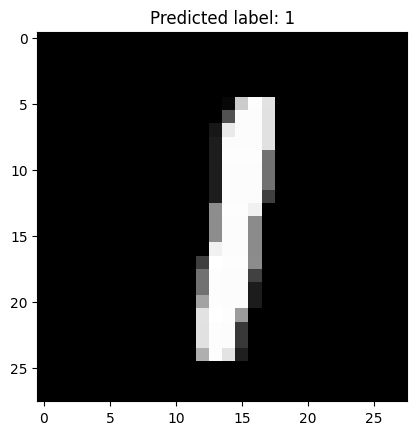

In [1]:
import contextlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Setting up the data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
with contextlib.redirect_stdout(None):
    train_dataset = torchvision.datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root="./data", train=False, download=True, transform=transform
    )
print(
    "MNIST dataset loaded successfully"
    if len(train_dataset) > 0 and len(test_dataset) > 0
    else "Loading MNIST dataset failed"
)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1, self.fc2 = nn.Linear(28 * 28, 500), nn.Linear(500, 10)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x.view(-1, 28 * 28))))

    def predict(self, input_image):
        with torch.no_grad():
            x = torch.tensor(input_image, dtype=torch.float32).view(1, 28, 28)
            _, predicted = torch.max(model(x).data, 1)
            return predicted


model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 4
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        outputs = model(data)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 200 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}"
            )

# Testing the model
model.eval()
with torch.no_grad():
    correct, total = 0, 0
    for data, targets in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(
        f"Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%"
    )

# Displaying the first image in the test set
plt.title(f"Predicted label: {predicted[0].item()}")
plt.imshow(data[0].view(28, 28).numpy(), cmap="gray")
plt.show()

In [2]:
from ipysketch_lite import Sketch
from PIL import Image
import numpy as np

sketch = Sketch(width=100, height=100)

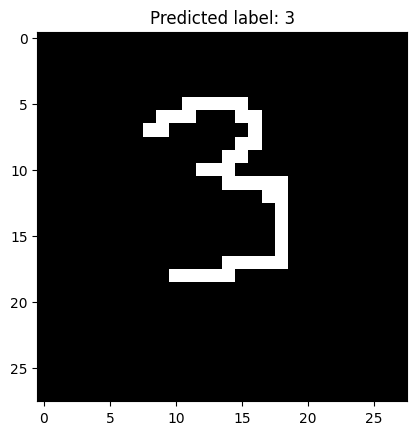

In [3]:
image = sketch.image
image = image.resize((28, 28), resample=0)

image_array = np.array(image)
out = np.sum(image_array, axis=2) > 0

# Make a prediction with the sketch
predicted = model.predict(out)

plt.title(f"Predicted label: {predicted[0].item()}")
plt.imshow(out, cmap="gray")
plt.show()